In [1]:
from datasets import get_dataloaders

from easydict import EasyDict as edict
from train_lightning import train
import wandb
import os

os.environ["TORCH_HOME"] = "~/storage/cache"
args = edict()
args.train_method = "encoder_erm"
args.dataset = "idsprites"
args.data_dir = f"/mnt/nas2/GrimaRepo/araymond/{args.dataset}" 
args.num_epochs = 100
args.pretrained_feats = False
args.pretrained_id = "yxmihnpi" #"am7g7cqg"
args.pretrained_epoch = 50
args.pretrain_method = "rep_train" # Method which trained the pretrained model
args.pretrained_reps = None # "vit_b_16" #"vit_b_16" # only use with train_method == "rep_train"
args.resume = False
args.experiment_id = None 
args.encoder = {
    'pretrained': False,
   # 'output_dim': 384, # vit_b_16: 784, vit_b_32: 784 # vit: 384.
    'id': args.pretrained_id,
    'epoch': args.pretrained_epoch,
    "pretrain_method": args.pretrain_method,
    "pretrain_reps": "vit_b_32", # reps used for pretraining
    'arch': 'lvit',
    'frozen': True}
args.pretrained_arch = args.encoder['arch'] if args.encoder['pretrained'] and args.encoder['frozen'] else None


args.seed = 444
args.test = True
args.save_weights = not args.test
args.save_metrics = not args.test
args.save_every = 10
args.num_workers = 0
METRICS_PER_METHOD = {
                      "erm": ['acc'],
                      "task_jepa": ['acc'], 
                      "ijepa": ['acc'],
                      "task_jepa+erm": ['acc'],
                      "pair_erm": ["acc"],
                      "encoder_erm": ['acc'],
                        "rep_train": ["acc"]
                     }

FOVS = {"shapes3d": {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15},
        "idsprites": {'shape': 10, 'scale': 10, 'orientation': 10, 
                          'x': 8, 'y': 4}
       }
FOVS_PER_DATASET = {'shapes3d': ["floor_hue", "wall_hue", "object_hue", "scale", "shape", "orientation"],
                   'idsprites': ["shape","scale","orientation","x","y"]
                   }
#FOVS_PER_DATASET = {'shapes3d': ["floor_hue", "wall_hue", "scale", "shape", "orientation"]}

args.best_model_criterion = "val_avg_acc"
args.metrics = METRICS_PER_METHOD[args.train_method]
args.fovs =  FOVS_PER_DATASET[args.dataset]
# Defines which tasks to optimize for when training under EncoderERM
args.fovs_tasks = args.fovs # ["floor_hue", "wall_hue", "object_hue", "scale", "shape", "orientation"]
args.fovs_indices = {name: i for i, name in enumerate(args.fovs)}
# When 2, 0 == same, 1 = different, When 3 levels, 0 = same, 1 = greater than, 2 = lower than
args.fovs_levels = {
                    'shapes3d': {"floor_hue": 2, "wall_hue": 2, "object_hue": 2, "scale": 3, "shape": 2, "orientation": 3},
                    'idsprites': {"shape": 3, "scale": 3, "orientation": 3, "x": 3, "y": 3}
                   }
args.fovs_ids = [args.fovs_indices[x] for x in args.fovs_tasks ]
args.n_fovs = FOVS[args.dataset]
args.task_to_label_index = {k: i for i, k in enumerate(args.fovs_tasks)}

/home/araymond/storage/pyenv/versions/3.10.14/envs/mini/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
There was a problem when trying to write in your cache folder (/storage/cache). You should set the environment variable TRANSFORMERS_CACHE to a writable directory.


In [12]:
from datasets import IdSprites, PairedDataset
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as transforms
from utils import set_seed
import torch 

def create_iidood_dls(args):
    datasets = dict()
    splits =  ['train','shape',"scale","orientation","x", "y"]
    for split in splits:
                datasets[split] = IdSprites(root_dir = args.data_dir,
                 split=split,
                 shuffle=True,
                 pretrained_arch = args.pretrained_arch if args.pretrained_arch is not None else args.pretrained_reps)
    
    train_size = int(0.8 * len(datasets['train']))  # 80% for training
    val_size = len(datasets['train']) - train_size  # The rest for validation
    
    # Split the dataset into training and validation
    set_seed(42)
    datasets['train'], datasets['val'] = random_split(datasets['train'], [train_size, val_size])
    # Load datasets
    
    # Create paired dataset
    paired_datasets = dict()
    splits =  ['shape',"scale","orientation","x", "y"]
    for split in splits:
        paired_datasets[split] = PairedDataset(datasets['val'], datasets[split], pair_mode='index')
    dls = {f"iid_ood_{k}": DataLoader(ds, batch_size=32, shuffle=False, collate_fn=pairwise_collate) for k, ds in paired_datasets.items()}
    return dls

def pairwise_collate(batch, train_method="encoder_erm"):   
    len_batch = len(batch[0])
    if len_batch == 2:
        x, y = torch.utils.data.default_collate(batch)
    else:
        x, reps, y = torch.utils.data.default_collate(batch)
    #print(batch[0].shape, batch[1].shape)
    #x, y = batch
    # define pairs and labels for pairwise training
    n_fovs = y[0].shape[-1]
    # create all pairs of input and target
    # Concatenate
    x = torch.cat((x[0],x[1]), dim=0)
    y = torch.cat((y[0],y[1]), dim=0)
    B, C, H, W = x.shape
    # only keep pairs where shapes are equal
    
    # Expand dimensions to create all pair combinations of images
    # x.unsqueeze(1) makes the shape (B, 1, C, H, W)
    # x.unsqueeze(0) makes the shape (1, B, C, H, W)
    image_pairs_1 = x.unsqueeze(1).expand(B, B, C, H, W)  # First element of the pairs (B, B, C, H, W)
    image_pairs_2 = x.unsqueeze(0).expand(B, B, C, H, W)  # Second element of the pairs (B, B, C, H, W)
    
    # Stack along a new dimension (2), so each pair is represented by (B, B, 2, C, H, W)
    all_image_pairs = torch.stack((image_pairs_1, image_pairs_2), dim=2)
    latents_diff1 = y.unsqueeze(1) - y.unsqueeze(0)
    #latents_diff = y[1] - y[0]
    #latents_diff = y.unsqueeze(1) - y.unsqueeze(0)
    latents_diff1 = latents_diff1.view(-1, n_fovs)
    # relabel diffs for classification
    # first for shape, floor color, wall color, object color, two values = 0 for same, 1 for different


    # For dimensions [3, 5]: set values > 0 to 1 and values < 0 to 2
    latents_diff1[:, [0, 1, 2, 3, 4]] = torch.where(latents_diff1[:, [0, 1, 2, 3, 4]] > 0, torch.tensor(1), latents_diff1[:, [0, 1, 2, 3, 4]])
    latents_diff1[:, [0, 1, 2, 3, 4]] = torch.where(latents_diff1[:, [0, 1, 2, 3, 4]] < 0, torch.tensor(2), latents_diff1[:, [0, 1, 2, 3, 4]])

    y = latents_diff1.long()
   
    all_image_pairs = all_image_pairs.view(-1, 2, C, H, W)
    # Make image pairs (input, target) and assign correct latents
    x_input = all_image_pairs[:,0].squeeze()
    x_target = all_image_pairs[:,1].squeeze()
    # Make image pairs (input, target) and assign correct latents

    # Let's filter x and y
    N, *_ = x_input.shape
    x_input1 =  torch.cat([x_input[:int(N/2)][i:i+B] for i in range(B, N, 2*B)]) # filter pairs that come from the same dataset
    x_input2 =  torch.cat([x_input[int(N/2):][i:i+B] for i in range(0, N, 2*B)]) # filter pairs that come from the same dataset
    x_target1 =  torch.cat([x_target[:int(N/2)][i:i+B] for i in range(B, N, 2*B)]) # filter pairs that come from the same dataset
    x_target2 =  torch.cat([x_target[int(N/2):][i:i+B] for i in range(0, N, 2*B)]) # filter pairs that come from the same dataset
    x_input = torch.cat((x_input1,x_input2),dim=0)
    x_target= torch.cat((x_target1,x_target2),dim=0)
    x = [x_input , x_target]
    y1 = torch.cat([y[:int(N/2)][i:i+B] for i in range(B, N, 2*B)]) # filter pairs that come from the same dataset
    y2 =  torch.cat([y[int(N/2):][i:i+B] for i in range(0, N, 2*B)]) # filter pairs that come from the same dataset
    #print(x_input.shape,y1.shape,y2.shape)
    y = torch.cat((y1,y2),dim=0).long()
     # If we have to handle representations as input
    if len_batch == 2:
        return x, y
    else:

        reps = torch.cat((reps[0],reps[1]), dim=0)
        B, D = reps.shape
        rep_pairs_1 = reps.unsqueeze(1).expand(B, B, D)  # First element of the pairs (B, B, D)
        rep_pairs_2 = reps.unsqueeze(0).expand(B, B, D)  # Second element of the pairs (B, B, D)

        # Stack along a new dimension (2), so each pair is represented by (B, B, 2, C, H, W)
        all_rep_pairs = torch.stack((rep_pairs_1, rep_pairs_2), dim=2)
        all_rep_pairs = all_rep_pairs.view(-1, 2, D)
        rep_input = all_rep_pairs[:,0].squeeze()
        rep_target = all_rep_pairs[:,1].squeeze()
        rep_input1 =  torch.cat([rep_input[:int(N/2)][i:i+B] for i in range(B, N, 2*B)]) # filter pairs that come from the same dataset
        rep_input2 =  torch.cat([rep_input[int(N/2):][i:i+B] for i in range(0, N, 2*B)]) # filter pairs that come from the same dataset
        rep_target1 =  torch.cat([rep_target[:int(N/2)][i:i+B] for i in range(B, N, 2*B)]) # filter pairs that come from the same dataset
        rep_target2 =  torch.cat([rep_target[int(N/2):][i:i+B] for i in range(0, N, 2*B)]) # filter pairs that come from the same dataset
        # Filter elements that come from the same splits
        rep_input = torch.cat((rep_input1,rep_input2),dim=0)
        rep_target= torch.cat((rep_target1,rep_target2),dim=0)
        
        reps = [rep_input , rep_target]

    if train_method in ["encoder_erm", "task_jepa"] :
        if len_batch == 3:
            return reps, y
        else:
            return x, y
    elif train_method == "rep_train":
        return x, reps, y
    else:
        return x, y
    
    return x, y

In [2]:
from models import create_model
import lightning as L
import torch
from datasets import get_dataloaders
from utils import get_args
from train_lightning import get_lightning_model
# Load model
exp_id = "t497198p"

# Define experiment ids for checkpoint
args = get_args(exp_id)
args.test = True

ckpt_path = f"results/idsprites/{exp_id}/epoch=49.ckpt"
#ckpt = torch.load(ckpt_path)
args.encoder['pretrain_method'] = None
model = get_lightning_model(args)

#m = create_model(args)



In [13]:
dls = create_iidood_dls(args)



In [14]:
batch = next(iter(dls['iid_ood_shape']))

In [6]:
dls['iid_ood_shape'].dataset.return_reps

True

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/araymond/storage/pyenv/versions/3.10.14/envs/mini/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Restoring states from the checkpoint path at results/idsprites/t497198p/epoch=49.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]
Loaded model weights from the checkpoint at results/idsprites/t497198p/epoch=49.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          id_loss          │    1.3638955354690552     │
│    id_orientation_acc     │    0.9264257550239563     │
│    id_orientation_loss    │    0.42878496646881104    │
│       id_scale_acc        │    0.8439440131187439     │
│       id_scale_loss       │    0.5702292919158936     │
│       id_shape_acc        │    0.6634752750396729     │
│       id_shape_loss       │     4.827088356018066     │
│         id_x_acc          │    0.7186197638511658     │
│         id_x_loss         │    0.7591853141784668     │
│         id_y_acc          │    0.9092903733253479     │
│         id_y_loss         │    0.2341868132352829     │
└───────────────────────────┴───────────────────────────┘

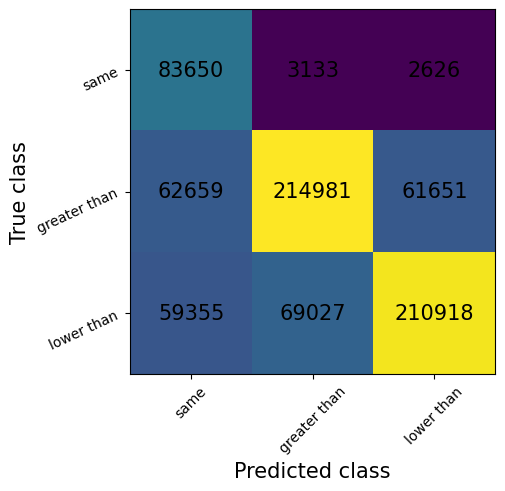

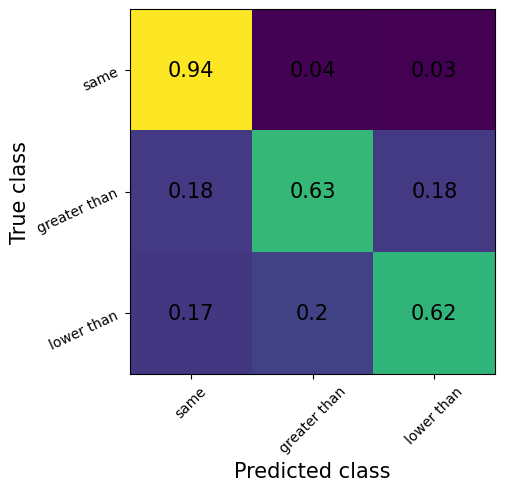

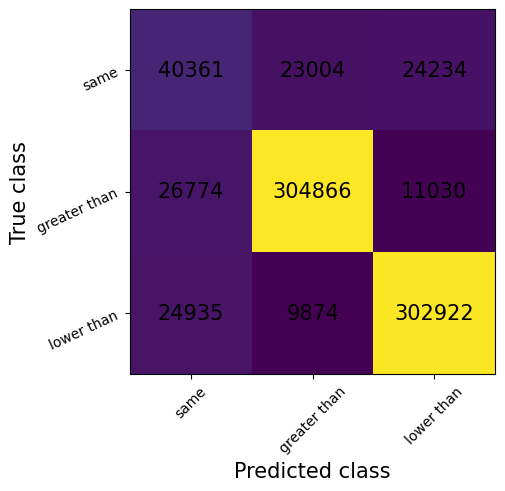

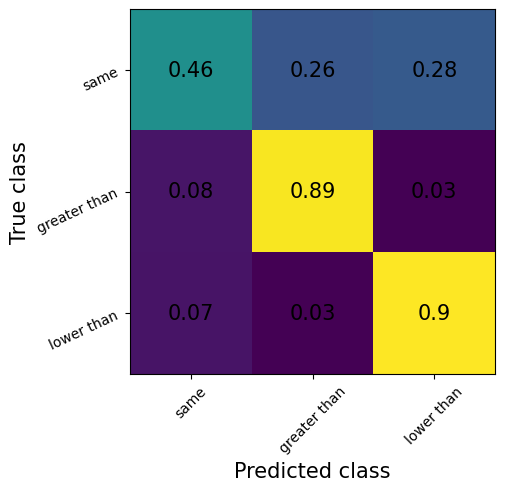

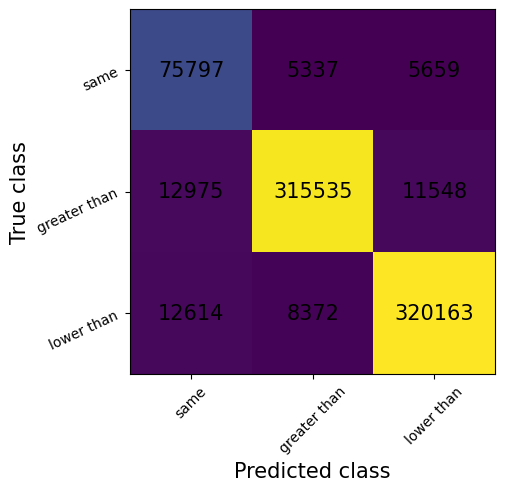

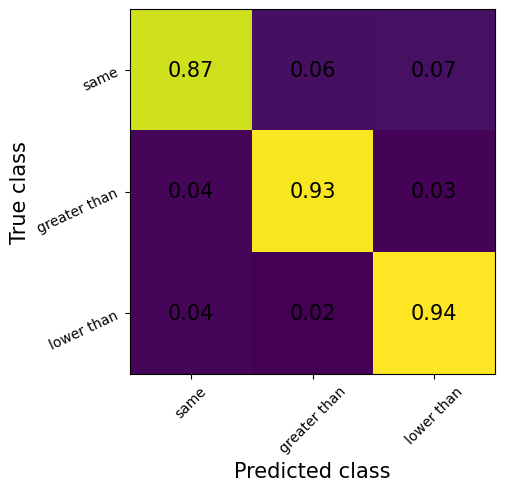

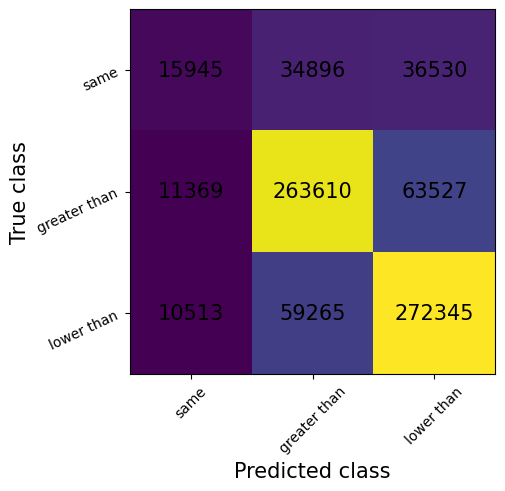

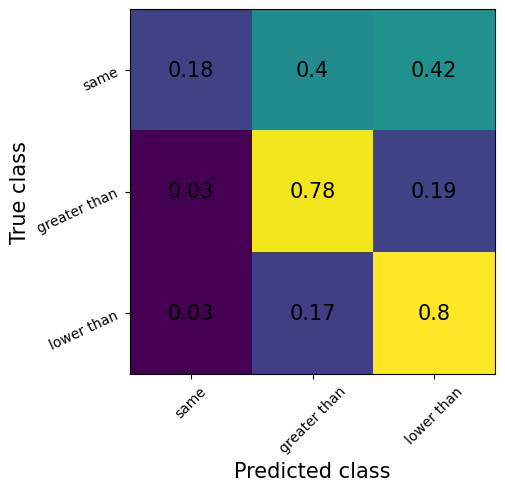

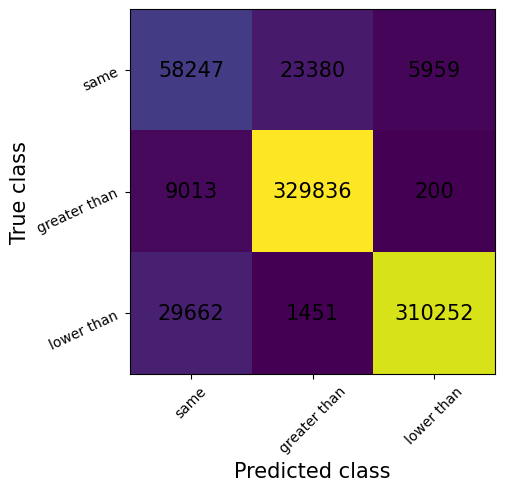

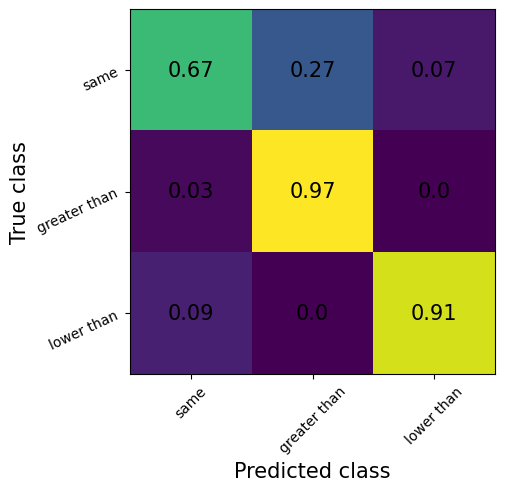

In [15]:

tester = L.Trainer(max_epochs=1,
                   accelerator="gpu",
                   devices=1)
splits =  ['shape']#,"scale","orientation","x", "y"]
splits = [f'iid_ood_{split}' for split in splits]

tester.test(
    model,
    ckpt_path=ckpt_path,
    dataloaders=[dls[split] for split in splits]
)

if not args.test:
    torch.save(tester.callback_metrics, f"results_iid_ood_{exp_id}.pth")

# import torch
torch.cuda.is_available()

In [60]:
x1 = torch.randn((3,4,1,1)).float()
x2 = torch.randn((3,4,1,1)).float()
x = [x1,x2]
y1 = torch.randn((3,5)).float() 
y2 =torch.randn((3,5)).float() 
y = [y1, y2]
#print(batch[0].shape, batch[1].shape)
#x, y = batch
# define pairs and labels for pairwise training
n_fovs = y[0].shape[-1]
# create all pairs of input and target
# Concatenate
x_cat = torch.cat((x[0],x[1]), dim=0)
y_cat = torch.cat((y[0],y[1]), dim=0)
B, C, H, W = x_cat.shape
# only keep pairs where shapes are equal

# Expand dimensions to create all pair combinations of images
# x.unsqueeze(1) makes the shape (B, 1, C, H, W)
# x.unsqueeze(0) makes the shape (1, B, C, H, W)
image_pairs_1 = x_cat.unsqueeze(1).expand(B, B, C, H, W)  # First element of the pairs (B, B, C, H, W)
image_pairs_2 = x_cat.unsqueeze(0).expand(B, B, C, H, W)  # Second element of the pairs (B, B, C, H, W)

# Stack along a new dimension (2), so each pair is represented by (B, B, 2, C, H, W)
all_image_pairs = torch.stack((image_pairs_1, image_pairs_2), dim=2)
latents_diff = y_cat.unsqueeze(1) - y_cat.unsqueeze(0)
#latents_diff = y[1] - y[0]
#latents_diff = y.unsqueeze(1) - y.unsqueeze(0)
latents_diff = latents_diff.view(-1, n_fovs)
# relabel diffs for classification
# first for shape, floor color, wall color, object color, two values = 0 for same, 1 for different


# For dimensions [3, 5]: set values > 0 to 1 and values < 0 to 2
latents_diff[:, [0, 1, 2, 3, 4]] = torch.where(latents_diff[:, [0, 1, 2, 3, 4]] > 0, torch.tensor(1), latents_diff[:, [0, 1, 2, 3, 4]])
latents_diff[:, [0, 1, 2, 3, 4]] = torch.where(latents_diff[:, [0, 1, 2, 3, 4]] < 0, torch.tensor(2), latents_diff[:, [0, 1, 2, 3, 4]])

y = latents_diff.long()

all_image_pairs = all_image_pairs.view(-1, 2, C, H, W)

# Make image pairs (input, target) and assign correct latents
x_input = all_image_pairs[:,0].squeeze()
x_target = all_image_pairs[:,1].squeeze()
#x1 = torch.cat((x_input,x_target), dim=0)
#x2 = torch.cat((x_target,x_input), dim=0)
#y = torch.cat((y1,y2), dim=0)
x = [x_input , x_target]